A barrier option is a type of derivative where the payoff depends on whether or not the underlying asset has reached or exceeded a predetermined price.

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.stats.distributions import norm
import random

# First Version

Simulating Stock Price

In [2]:
def simulate_price_path(S0, r, sigma, T, N, M): 
    dt = T/N
    paths = np.zeros((M, N + 1)) 
    paths[:, 0] = S0
    for i in range(1, N + 1):
        z = np.random.normal(0, 1, M)
        paths[:, i] = paths[:, i - 1] * np.exp((r - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) * z) 
    return paths

Computing Payoff of barrier option

In [3]:
def compute_payoff(paths, K, barrier, type='call'): 
    N = paths.shape[1] - 1
    if type == 'call':
        payoff = np.maximum(paths[:, N] - K, 0) 
    else:
        payoff = np.maximum(K - paths[:, N], 0) 
    hit_barrier = np.any(paths < barrier, axis=1) 
    payoff[hit_barrier] = 0
    return payoff

Plotting Price

In [4]:
def plot_price_paths(paths): 
    plt.plot(paths.T)
    plt.xlabel('Time Steps') 
    plt.ylabel('Stock Price') 
    plt.title('Simulated Stock Price Paths') 
    plt.show()

Defining Barrier option

In [5]:
def price_barrier_option(S0, r, sigma, T, K, barrier, N, M, type='call'): 
    paths = simulate_price_path(S0, r, sigma, T, N, M)
    payoff = compute_payoff(paths, K, barrier, type)
    option_price = np.exp(-r * T) * np.mean(payoff)
    return option_price

Inputs

In [6]:
S0 = 100.0 
r = 0.05 
sigma = 0.2 
T = 1.0
K = 100.0 
barrier = 80.0 
N = 365
M = 10000

In [7]:
price = price_barrier_option(S0, r, sigma, T, K, barrier, N, M) 
print('Barrier Option Price:', price)

Barrier Option Price: 10.439706056573586


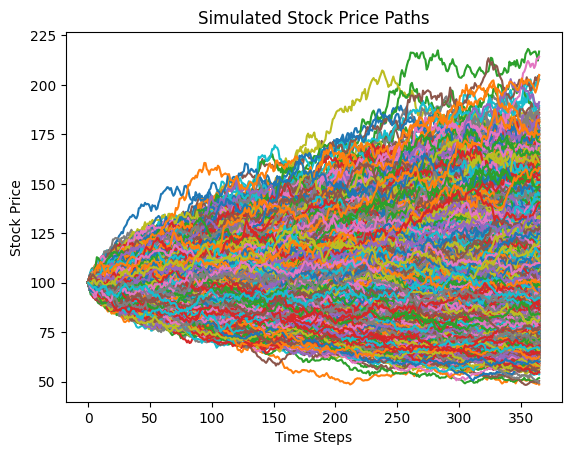

In [8]:
paths = simulate_price_path(S0, r, sigma, T, N, M) 
plot_price_paths(paths)

# Second Version

In [11]:
def bsm_barrier_option(k, s, h, t, r, sig, rebate, payoff, n, oi):
    # ================================================================================================
    # equations from the complete guide to option pricing formulas, second edition. pp.125-126
    # author and year: Espen Gaarder Haug (2018)
    # ================================================================================================
    
    """
    Parameters:
    k = strike price
    s = stock price
    h = barrier price
    t = t/T = time to maturity
    r = risk-less short rate
    sig = volatility of stock value
    rebate = refund (if any)
    payoff = "in" or "out" options
    oi: call = 1  put = -1
    n：down = 1  up = -1
    """
    miu = (- (sig ** 2) / 2) / (sig ** 2)
    la = math.sqrt(miu ** 2 + 2 * r / (sig ** 2))
    z = math.log(h / s, math.e) / (sig * math.sqrt(t)) + la * sig * math.sqrt(t)
    x1 = math.log(s / k, math.e) / (sig * math.sqrt(t)) + (1 + miu) * sig * math.sqrt(t)
    x2 = math.log(s / h, math.e) / (sig * math.sqrt(t)) + (1 + miu) * sig * math.sqrt(t)
    y1 = math.log((h ** 2) / (s * k), math.e) / (sig * math.sqrt(t)) + (1 + miu) * sig * math.sqrt(t)
    y2 = math.log(h / s, math.e) / (sig * math.sqrt(t)) + (1 + miu) * sig * math.sqrt(t)

    A = oi * s * math.exp(-r * t) * norm.cdf(oi * x1) - oi * k * math.exp(-r * t) * norm.cdf(
        oi * x1 - oi * sig * math.sqrt(t))
    B = oi * s * math.exp(-r * t) * norm.cdf(oi * x2) - oi * k * math.exp(-r * t) * norm.cdf(
        oi * x2 - oi * sig * math.sqrt(t))
    C = oi * s * math.exp(-r * t) * (h / s) ** (2 * miu + 2) * norm.cdf(n * y1) - oi * k * math.exp(-r * t) * ((
            h / s) ** (2 * miu)) * norm.cdf(n * y1 - n * sig * math.sqrt(t))
    D = oi * s * math.exp(-r * t) * ((h / s) ** (2 * miu + 2)) * norm.cdf(n * y2) - oi * k * math.exp(-r * t) * ((
            h / s) ** (2 * miu)) * norm.cdf(n * y2 - n * sig * math.sqrt(t))
    E = rebate * math.exp(-r * t) * (norm.cdf(n * x2 - n * sig * math.sqrt(t)) - ((h / s) ** (2 * miu)) * norm.cdf(
        n * y2 - n * sig * math.sqrt(t)))
    F = rebate * (((h / s) ** (miu + la)) * norm.cdf(n * z) + ((h / s) ** (miu - la)) * norm.cdf(
        n * z - 2 * n * la * sig * math.sqrt(t)))

    value = 0
    if payoff == "in":
        if n == 1 and oi == 1:  # down-and-in call options
            if k > h:
                value = C + E

            else:
                value = A - B + D + E

        elif n == -1 and oi == 1:  # up-and-in call options
            if k > h:
                value = A + E
            else:
                value = B - C + D + E

        elif n == 1 and oi == -1:  # down-and-in put options
            if k > h:
                value = B - C + D + E
            else:
                value = A + E

        elif n == -1 and oi == -1:  # up-and-in put options
            if k > h:
                value = A - B + D + E
            else:
                value = C + E

    else:
        if n == 1 and oi == 1:  # down-and-out call options
            if k > h:
                value = A - C + F

            else:
                value = B - D + F

        elif n == -1 and oi == 1:  # up-and-out call options向上敲出认购
            if k > h:
                value = F
            else:
                value = A - B + C - D + F

        elif n == 1 and oi == -1:  # down-and-out put options
            if k > h:
                value = A - B + C - D + F
            else:
                value = F

        elif n == -1 and oi == -1:  # up-and-out put options
            if k > h:
                value = B - D + F
            else:
                value = A - C + F

    return value

In [12]:
def mc_barrier_option(s0, t, r, k, sig, m, n, h, rebate, towards, w, x):
    """
    Parameters:
    s0 = initial stock price
    t = t/T = time to maturity
    r = risk-less short rate
    k = strike price
    sig = volatility of stock value
    m = the number of path nodes
    n = the number of simulation
    h = barrier price
    rebate = 退款
    towards: 1=up   -1=down
    w: 1=call； -1=put
    x: 1=in； -1=out
    """
    delta_t = t / m  # length of time interval
    list_price = []
    for i in range(0, n):
        path = [s0]
        for j in range(0, m):
            path.append(path[-1]*math.exp((r-0.5*sig**2)*delta_t+(sig*math.sqrt(delta_t)*random.gauss(0, 1))))

        # it is based on the definition of standard barrier option
        if towards == -1:
            if (x == 1 and min(path) <= h) or (x == -1 and min(path) > h):
                price = max(math.exp(-r * delta_t)*(w * path[-1] - w * k), 0)
            else:
                price = rebate

        else:
            if (x == 1 and max(path) >= h) or (x == -1 and max(path) < h):
                price = max(math.exp(-r * delta_t)*(w * path[-1] - w * k), 0)
            else:
                price = rebate

        list_price.append(price)
    value = np.average(list_price)

    return value

In [13]:
analytical_solution = bsm_barrier_option(100, 100, 105, 0.08, 0.03, 0.2, 0, "out", -1, 1)
print("analytical_solution = ", analytical_solution)

analytical_solution =  0.2636325380175846


In [14]:
arithmetic_solution = mc_barrier_option(100, 0.08, 0.03, 100, 0.2, 100, 100000, 105, 0, 1, 1, -1)
print("arithmetic_solution = ", arithmetic_solution)

arithmetic_solution =  0.3309888115146003
